<a href="https://colab.research.google.com/github/DrakeData/NLP-Disaster_Tweets/blob/main/NLP_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Disaster Tweets
The data is from a [Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/overview) titled "Natural Language Processing with Disaster Tweets". The objective is to use NLP with disaster tweets to determine whether a tweet refers to a disaster or not.

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
import random
import os
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score
from keras.callbacks import CSVLogger
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU
from keras.layers import Dense, Embedding, Bidirectional, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from nltk.stem import SnowballStemmer
import re
import tensorflow_hub as hub

## Ingest
Donwloading the data from Kaggle's API

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp './drive/MyDrive/Colab Notebooks/API Keys/kaggle.json' ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download nlp-getting-started

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


The below line of code allows us to download Global Vectors for Word Representation (GloVe). 

From [GloVe's Documentation](https://nlp.stanford.edu/projects/glove/): GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

In [7]:
! wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-03-07 01:56:54--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-07 01:56:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-07 01:56:55--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [8]:
! unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
train_df = pd.read_csv('train.csv')

test_df = pd.read_csv('test.csv')

## EDA
Exploratory Data Analysis


In [10]:
# Look at random sample of 10
train_df.sample(10)

,id,keyword,location,text,target
2807,4038,disaster,los angeles,Keeps askin me what this means\nNot like i got...,1
2934,4216,drowned,Colorado Springs,http://t.co/riWuP1RbHu Jacksonville family ban...,0
3858,5488,flames,"Sioux Falls, S.D.",RP said they can see smoke coming from the sil...,1
1981,2852,cyclone,Made in America,Cyclone by Double G would be the cherry on top...,0
6325,9041,stretcher,3???2???????,ÛÏStretcher in 5 min // Speaker DeckÛ http:...,0
4991,7121,military,NaN,13 reasons why we love women in the military ...,0
1282,1848,burned,NaN,Holy fuck QVC bitch just got burned so hard.,0
1251,1807,buildings%20on%20fire,UK,#TweetLikeItsSeptember11th2001 Those two build...,1
6176,8808,sirens,"Denver, CO",#SirensIcebreaker What is one fantasy work abo...,0
5032,7175,mudslide,NaN,You've 100% fucked up when Paul says your cake...,0


Column notes:
- id: tweet unique identifier
- keyword: keyword from the tweet; can return blank
- location: location that the tweet was sent from; can return blank
- text: text from tweet
- target: labels the tweet if the tweet is about a real disaster (1) or not (0)

In [11]:
# Check shape of data sets
print(f"Train data set shape: {train_df.shape}")
print(f"Test data set shape: {test_df.shape}")

Train data set shape: (7613, 5)
Test data set shape: (3263, 4)


In [12]:
# Check missing values
print(f"Train Dataset missing data: \n{train_df.isnull().sum()}\n")
print(f"Test Dataset missing data: \n{test_df.isnull().sum()}")

Train Dataset missing data: 
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Test Dataset missing data: 
id             0
keyword       26
location    1105
text           0
dtype: int64


In [13]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

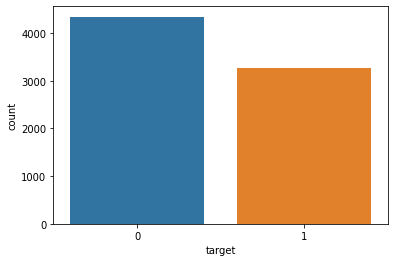

In [14]:
sns.countplot(x='target', data=train_df);

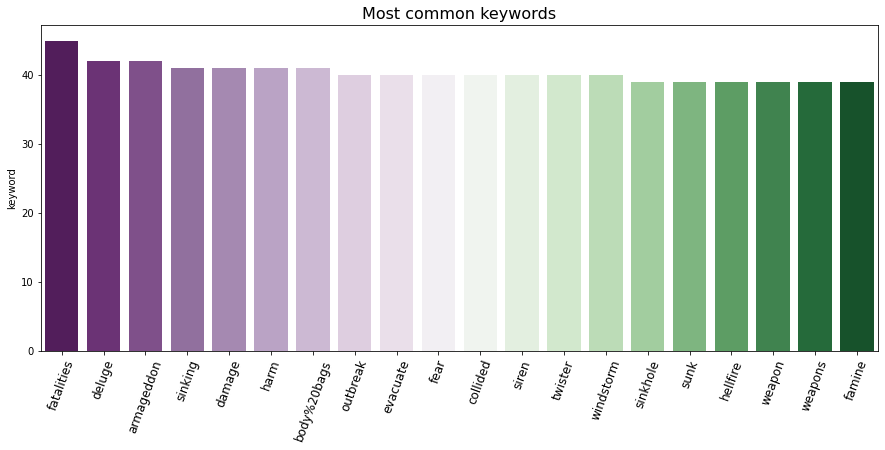

In [15]:
# Check key words
keywords_check = train_df["keyword"].value_counts()[:20].to_frame()

fig = plt.figure(figsize=(15,6))
sns.barplot(data=keywords_check, x=keywords_check.index, y="keyword", palette="PRGn")
plt.title("Most common keywords",size=16)
plt.xticks(rotation=70,size=12);

### Preprocessing
- Make all text lowercase
- Remove special characters
- Remove numbers 
- Remove stop words
- Remove extra spacing (whitespace)
- Remove weblinks
- Expand contractions when possible
- Stemming - reduce extra characters from a word to its root or base of a word.
- Tokenize - task of breaking a phrase into smaller sections



In [16]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
def remove_emoji(string):
  '''
  Remove emojies from text
  '''
  emoji_pattern = re.compile("["
  u"\U0001F600-\U0001F64F"
  u"\U0001F300-\U0001F5FF"
  u"\U0001F680-\U0001F6FF"
  u"\U0001F1E0-\U0001F1FF"
  u"\U00002702-\U000027B0"
  u"\U000024C2-\U0001F251"
  u"\U0001f926-\U0001f937"
  u'\U00010000-\U0010ffff'
  u"\u200d"
  u"\u2640-\u2642"
  u"\u2600-\u2B55"
  u"\u23cf"
  u"\u23e9"
  u"\u231a"
  u"\u3030"
  u"\ufe0f"
  "]+", flags=re.UNICODE)
  
  return emoji_pattern.sub(r' ', string)

In [18]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english') 

def preprocess(sentence):
  # dtype to string
  sentence=str(sentence)
  # lowercase
  sentence = sentence.lower()
  # remove html links
  sentence = sentence.replace('{html}',"")
  # remove emojies
  sentence = remove_emoji(sentence)
  # remove special characters
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', sentence)
  # remove urls
  rem_url=re.sub(r'http\S+', '',cleantext)
  # remove numbers
  rem_num = re.sub('[0-9]+', '', rem_url)

  # tokenize text
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)

  # remove stopwords  
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  # stemming
  stem_words=[stemmer.stem(w) for w in filtered_words]
  lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
  
  return " ".join(filtered_words)

text_ls = ['keyword', 'location', 'text']


# Clean train_df
for col in text_ls:
  for i in range(len(train_df[col])):
    train_df[col][i] = preprocess(train_df[col][i])

# Clean test_df
for col in text_ls:
  for i in range(len(test_df[col])):
    test_df[col][i] = preprocess(test_df[col][i])

print("\nTrain Set:")
train_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Train Set:


,id,keyword,location,text,target
0,1,nan,nan,deeds reason earthquake may allah forgive,1
1,4,nan,nan,forest fire near ronge sask canada,1
2,5,nan,nan,residents asked shelter place notified officer...,1
3,6,nan,nan,people receive wildfires evacuation orders cal...,1
4,7,nan,nan,got sent photo ruby alaska smoke wildfires pou...,1


In [19]:
train_df.sample(10)

,id,keyword,location,text,target
1160,1671,bridge collapse,vitì_ria,marshall plan united states dambisa moyo via p...,0
2602,3736,destroyed,studio,flood two people dead houses destroyed kaduna ...,1
7142,10234,volcano,ted inc ireland europe,songhey well also gay girls like predict tsuna...,0
2282,3276,demolish,hooters peachtree,nothing midget demolish show respect,0
1660,2397,collapsed,nan,look collapsed attempting munch endangered spe...,0
1243,1791,buildings fire,nigeria global,kenya several buildings reported fire close da...,1
1784,2560,crash,nan,sterlingknight car crashsterling driving carme...,0
5139,7329,nuclear reactor,london heart sea,rolling sandunes gentle lapping sea call gulls...,1
4391,6243,hijacking,perth australia,hot funtenna hijacking computers send data sou...,0
2147,3082,deaths,weyburn,weyburn police warn public fentanyl deaths pro...,1


### Text Encoding
As the model won't understand what to do with the string variables creating a sentence, we will need to encode the words. To this this, we will convert the words into an array of numbers representing the sentence. The tokenizer will assign a number index to every unique word so that the model can treat it like a categorical value.

In [20]:
def define_tokenizer(train_sentences, val_sentences, test_sentences):
  '''
  Takes the train, val, and test data sets and assigning an index number to every word present in the sentences.
  '''
  sentences = pd.concat([train_sentences, val_sentences, test_sentences])
  
  tokenizer = tf.keras.preprocessing.text.Tokenizer()
  tokenizer.fit_on_texts(sentences)
  
  return tokenizer
    
def encode(sentences, tokenizer):
  '''
  Takes the tokenizer to encode all the sentences into an array of index numbers representing the sentence
  '''
  encoded_sentences = tokenizer.texts_to_sequences(sentences)
  encoded_sentences = tf.keras.preprocessing.sequence.pad_sequences(encoded_sentences, padding='post')
  
  return encoded_sentences

In [21]:
# Split out data into train, val, test set
val_data = train_df.tail(1500)
train_data = train_df.head(6113)
test_data = test_df

In [22]:
tokenizer = define_tokenizer(train_data['text'], val_data['text'], test_data['text'])

encoded_sentences = encode(train_data['text'], tokenizer)
val_encoded_sentences = encode(val_data['text'], tokenizer)
encoded_test_sentences = encode(test_data['text'], tokenizer)

In [23]:
tokenizer.word_index['disaster']

12

In [24]:
len(tokenizer.word_index)

19999

In [25]:
# Check if sentences  are lowercase
print(f"Lower: {tokenizer.get_config()['lower']}")

# Check the split to get the words from the sentences
print(f"Split: {tokenizer.get_config()['split']}")

# what characters are filters out
print(f"Filters: {tokenizer.get_config()['filters']}")

Lower: True
Split:  
Filters: !"#$%&()*+,-./:;<=>?@[\]^_`{|}~	



### Use GloVe Embedding
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. Documentation can be [found here](https://nlp.stanford.edu/projects/glove/).

In [26]:
embedding_dict = {}

with open('./glove.6B.100d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
        
f.close()

Match encoding of the tokenizer with the embeddings by updating the encoded words in the embedding with the encoding from the tokenizer.

In [27]:
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in tokenizer.word_index.items():
    if i > num_words:
        continue
    
    emb_vec = embedding_dict.get(word)
    
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

## Modeling

### Model 1

#### Setup Pipeline
We will create a pipeline that:
- Shuffle the data per training step
- Process the next batch of data for training while the current batch of data is training
- Defining each batch as a padded batch

In [28]:
tf_data = tf.data.Dataset.from_tensor_slices((encoded_sentences, train_data['target'].values))

def pipeline(tf_data, buffer_size=100, batch_size=32):
    tf_data = tf_data.shuffle(buffer_size)    
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    tf_data = tf_data.padded_batch(batch_size, padded_shapes=([None],[]))
    
    return tf_data

tf_data = pipeline(tf_data, buffer_size=1000, batch_size=32)

In [29]:
print(tf_data)

<PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [30]:
# create pipeline for validation set
tf_val_data = tf.data.Dataset.from_tensor_slices((val_encoded_sentences, val_data['target'].values))

def val_pipeline(tf_data, batch_size=1):        
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    tf_data = tf_data.padded_batch(batch_size, padded_shapes=([None],[]))
    
    return tf_data

tf_val_data = val_pipeline(tf_val_data, batch_size=len(val_data))

In [31]:
print(tf_val_data)

<PaddedBatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


#### Train Model

In [32]:
embedding = tf.keras.layers.Embedding(
    len(tokenizer.word_index) + 1,
    100,
    embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix),
    trainable = True
)

In [33]:
model = tf.keras.Sequential([
    embedding,
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy', 'Precision', 'Recall']
)

In [35]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [36]:
history = model.fit(
    tf_data, 
    validation_data = tf_val_data,
    epochs = 50,
    callbacks = callbacks
)

clear_output()

In [37]:
# save model
model.save(
    'drive/MyDrive/Colab Notebooks/NLP_Disaster_Tweets/model1.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

In [38]:
# # Read in model
# model = load_model('drive/MyDrive/Colab Notebooks/NLP_Disaster_Tweets/model1.h5')

In [39]:
metrics = model.evaluate(tf_val_data)
# print(model.metrics_names)


precision = metrics[2]
recall = metrics[3]
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy score: {metrics[1]}')
print(f'F1 score: {str(f1)}') 

1/1 [==============================] - 0s 411ms/step - loss: 0.5473 - accuracy: 0.7980 - precision: 0.7896 - recall: 0.7773
Accuracy score: 0.7979999780654907
F1 score: 0.7834167108374794


In [40]:
data = {'loss': history.history['loss'],
        'accuracy':  history.history['accuracy'],
        'precision': history.history['precision'],
        'recall': history.history['recall'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
        }

hist_df = pd.DataFrame(data)

hist_df.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy
0,0.580688,0.714543,0.750458,0.479345,0.436889,0.802667
1,0.475942,0.784230,0.786931,0.666407,0.420009,0.813333
2,0.451377,0.794536,0.795845,0.686672,0.413625,0.812667
3,0.436516,0.807623,0.813911,0.702260,0.411340,0.810000
4,0.430040,0.813349,0.819364,0.712393,0.407956,0.816667


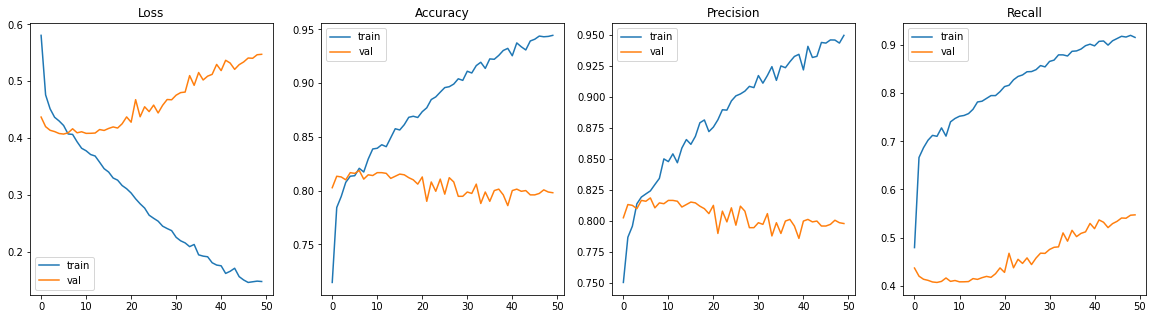

In [51]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].set_title('Loss')
axs[0].plot(hist_df['loss'], label='train')
axs[0].plot(hist_df['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(hist_df['accuracy'], label='train')
axs[1].plot(hist_df['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(hist_df['precision'], label='train')
axs[2].plot(hist_df['val_accuracy'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(hist_df['recall'], label='train')
axs[3].plot(hist_df['val_loss'], label='val')
axs[3].legend()

In [43]:
# Check for number of false positives
predictions = model.predict(tf_val_data)
predictions = np.concatenate(predictions).round().astype(int)
val_data['predictions'] = predictions

false_positives = val_data[(val_data['predictions'] == 1) & (val_data['target'] == 0)]

print(f'Count of false positives: {str(len(false_positives))}\n\n')

Count of false positives: 146




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [44]:
# Look at false positives
false_positives.head(10)

,id,keyword,location,text,target,predictions
6121,8737,sinking,london,slowly sinking wasting edsheeran,0,1
6161,8787,siren,nan,hate damn milwaukee indyfest cars sound like r...,0,1
6231,8896,snowstorm,nan,yall poem called one snowstorm meet space one ...,0,1
6233,8900,snowstorm,huntington,sorry built fire desk already irishirr mchapma...,0,1
6240,8912,snowstorm,south usa,sassy city girl country hunk stranded smoky mo...,0,1
6244,8920,snowstorm,deployed middle east,cacheadvance besides nasty thunderstorm snowst...,0,1
6257,8941,snowstorm,italy,snowstorm planned outside rome mary major toni...,0,1
6258,8942,storm,nan,finally storm,0,1
6272,8962,storm,philly,okay welcome rain gave storm could weather,0,1
6277,8968,storm,johns creek,storm,0,1


In [45]:
# Check for number of false negatives
false_negatives = val_data[(val_data['predictions'] == 0) & (val_data['target'] == 1)]

print(f'Count of false negatives: {str(len(false_negatives))}')

Count of false negatives: 157


In [46]:
# Look at false negatives
false_positives.tail(10)

,id,keyword,location,text,target,predictions
7437,10640,wounds,newcastle england,nout like rubbin salt wounds dad,0,1
7442,10650,wounds,earth,dianneg gunshot wound bicep wounds chest torso...,0,1
7445,10656,wounds,lake highlands,crack path wiped morning beach run surface wou...,0,1
7448,10659,wounds,nan,puncture wounds,0,1
7453,10666,wounds,cape town,thought surgical wounds healed weather helping...,0,1
7459,10675,wounds,north carolina,court back session testimony continues med exa...,0,1
7467,10684,wounds,charlotte,says many wounds could fatal rather quickly ot...,0,1
7497,10724,wreck,innsmouth mass,staged locomotive wreck could possibly wrong,0,1
7548,10789,wrecked,pennsylvania,four hundred wrecked cars costing apiece purch...,0,1
7551,10794,wrecked,nan,freeway africa til wrecked audi,0,1


#### Make Prediction

In [47]:
tf_test_data = tf.data.Dataset.from_tensor_slices((encoded_test_sentences))

def test_pipeline(tf_data, batch_size=1):        
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)
    tf_data = tf_data.padded_batch(batch_size, padded_shapes=([None]))
    
    return tf_data

tf_test_data = test_pipeline(tf_test_data)

In [48]:
pred = model.predict(tf_test_data)

In [49]:
pred = np.concatenate(pred).round().astype(int)

In [50]:
sub = pd.DataFrame(data={'target': pred}, index=test_data['id'])
sub.index = sub.index.rename('id')
sub.to_csv('drive/MyDrive/Colab Notebooks/NLP_Disaster_Tweets/submission1.csv')

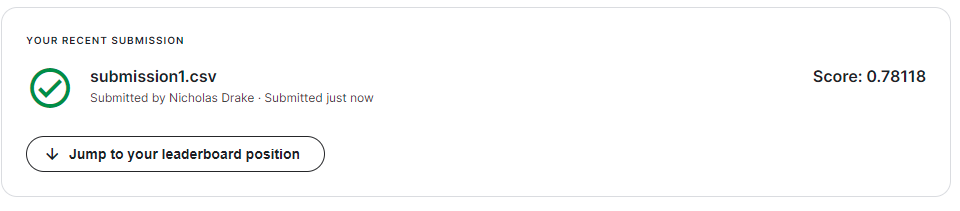

### Model 2
Adding a density layer

#### Setup Model

In [64]:
model2 = tf.keras.Sequential([
    embedding,
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [65]:
model2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=['accuracy', 'Precision', 'Recall']
)

In [66]:
callbacks2 = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

#### Train Model

In [67]:
history2 = model2.fit(
    tf_data, 
    validation_data = tf_val_data,
    epochs = 50,
    callbacks = callbacks2
)

clear_output()

In [100]:
metrics2 = model2.evaluate(tf_val_data)
# print(model.metrics_names)


precision2 = metrics2[2]
recall2 = metrics2[3]
f1 = 2 * (precision2 * recall2) / (precision2 + recall2)

print(f'Accuracy score: {metrics2[1]}')
print(f'F1 score: {str(f1)}') 

1/1 [==============================] - 1s 782ms/step - loss: 0.6189 - accuracy: 0.7140 - precision: 0.6601 - recall: 0.8071
Accuracy score: 0.7139999866485596
F1 score: 0.7262284725308885


In [69]:
data2 = {'loss': history2.history['loss'],
        'accuracy':  history2.history['accuracy'],
        'precision': history2.history['precision'],
        'recall': history2.history['recall'],
        'val_loss': history2.history['val_loss'],
        'val_accuracy': history2.history['val_accuracy']
        }

hist_df2 = pd.DataFrame(data2)

hist_df2.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy
0,0.677187,0.606085,0.602332,0.181216,0.676697,0.560000
1,0.651826,0.637985,0.639305,0.315666,0.643594,0.633333
2,0.614125,0.667921,0.655093,0.441154,0.597277,0.692000
3,0.583327,0.698675,0.680459,0.531956,0.592442,0.701333
4,0.562959,0.717160,0.702272,0.566251,0.584327,0.706667


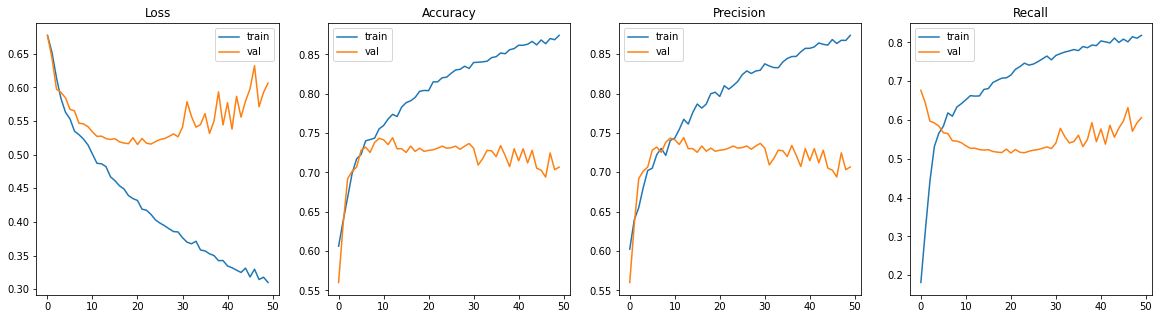

In [70]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].set_title('Loss')
axs[0].plot(hist_df2['loss'], label='train')
axs[0].plot(hist_df2['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(hist_df2['accuracy'], label='train')
axs[1].plot(hist_df2['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(hist_df2['precision'], label='train')
axs[2].plot(hist_df2['val_accuracy'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(hist_df2['recall'], label='train')
axs[3].plot(hist_df2['val_loss'], label='val')
axs[3].legend()

#### Make Prediction

In [71]:
pred2 = model2.predict(tf_test_data)

In [72]:
pred2 = np.concatenate(pred2).round().astype(int)

In [73]:
sub2 = pd.DataFrame(data={'target': pred2}, index=test_data['id'])
sub2.index = sub2.index.rename('id')
sub2.to_csv('drive/MyDrive/Colab Notebooks/NLP_Disaster_Tweets/submission2.csv')

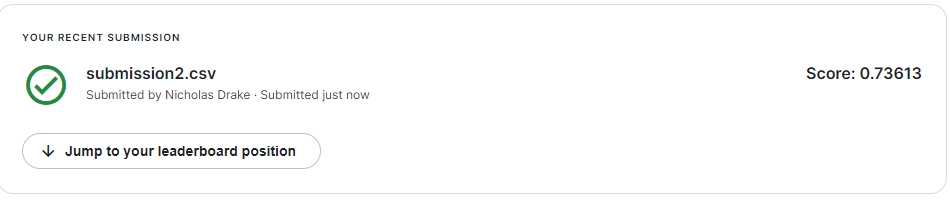

This model did not preform as well as the first model, but it was close.

### Model 3

#### Setup Model

In [95]:
model3 = tf.keras.Sequential([
    embedding,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [96]:
model3.compile(
  loss="binary_crossentropy",
  optimizer=tf.keras.optimizers.Adam(),
  metrics=['accuracy', 'Precision', 'Recall']
)

In [97]:
callbacks3 = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

#### Train Model

In [98]:
history3 = model3.fit(
    tf_data, 
    validation_data = tf_val_data,
    epochs=50,
    callbacks = callbacks3
)

clear_output()

In [99]:
metrics3 = model3.evaluate(tf_val_data)
# print(model.metrics_names)


precision3 = metrics3[2]
recall3 = metrics3[3]
f1 = 2 * (precision3 * recall3) / (precision3 + recall3)

print(f'Accuracy score: {metrics3[1]}')
print(f'F1 score: {str(f1)}')

1/1 [==============================] - 1s 614ms/step - loss: 1.3124 - accuracy: 0.6713 - precision: 0.6302 - recall: 0.7277
Accuracy score: 0.6713333129882812
F1 score: 0.6754443740027968


In [102]:
data3 = {'loss': history3.history['loss'],
        'accuracy':  history3.history['accuracy'],
        'precision': history3.history['precision'],
        'recall': history3.history['recall'],
        'val_loss': history3.history['val_loss'],
        'val_accuracy': history3.history['val_accuracy']
        }

hist_df3 = pd.DataFrame(data3)

hist_df3.head()

,loss,accuracy,precision,recall,val_loss,val_accuracy
0,0.333287,0.852282,0.862309,0.771239,0.803743,0.712667
1,0.101410,0.961067,0.962639,0.943882,0.945741,0.698000
2,0.081193,0.970064,0.972255,0.955963,1.020904,0.698000
3,0.064716,0.974644,0.973674,0.965705,1.016286,0.684667
4,0.070552,0.973499,0.970634,0.966095,0.974828,0.698667


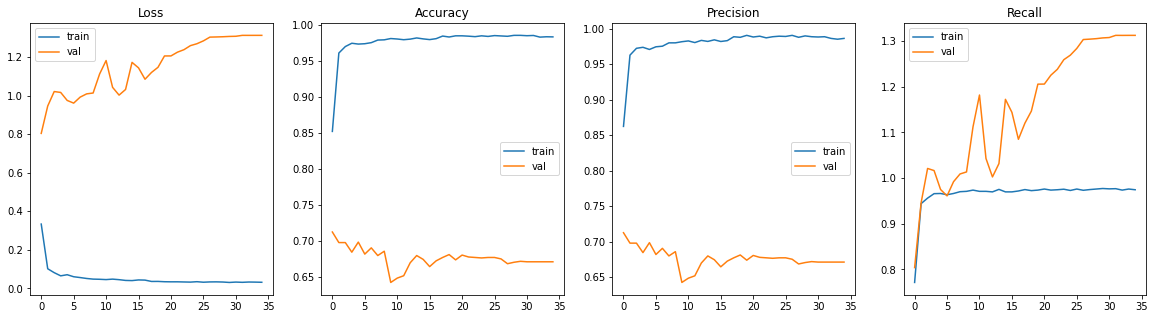

In [103]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].set_title('Loss')
axs[0].plot(hist_df3['loss'], label='train')
axs[0].plot(hist_df3['val_loss'], label='val')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(hist_df3['accuracy'], label='train')
axs[1].plot(hist_df3['val_accuracy'], label='val')
axs[1].legend()

axs[2].set_title('Precision')
axs[2].plot(hist_df3['precision'], label='train')
axs[2].plot(hist_df3['val_accuracy'], label='val')
axs[2].legend()

axs[3].set_title('Recall')
axs[3].plot(hist_df3['recall'], label='train')
axs[3].plot(hist_df3['val_loss'], label='val')
axs[3].legend()

#### Make Prediction

In [104]:
pred3 = model3.predict(tf_test_data)

In [105]:
pred3 = np.concatenate(pred3).round().astype(int)

In [106]:
sub3 = pd.DataFrame(data={'target': pred3}, index=test_data['id'])
sub3.index = sub3.index.rename('id')
sub3.to_csv('drive/MyDrive/Colab Notebooks/NLP_Disaster_Tweets/submission3.csv')

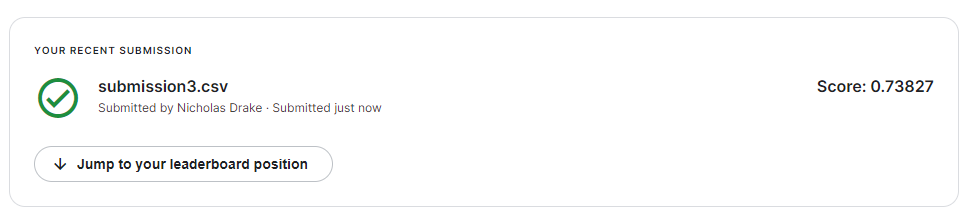

All 3 models preformed very similar with their Kaggle score around .73; Model 1 had the best performance.